In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_csv('Mall_Customers.csv')
# modify column name
df = df.rename(columns = {'Annual Income (k$)':'Annual Income',
                         'Spending Score (1-100)':'Spending Score'})

df.head()

,CustomerID,Gender,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [132]:
# CustomerID는 단순히 record 번호를 의미. clustering 하는데 필요X
# delete id
del df['CustomerID']

# Check the feature information of data
df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
Gender            200 non-null object
Age               200 non-null int64
Annual Income     200 non-null int64
Spending Score    200 non-null int64
dtypes: int64(3), object(1)
memory usage: 6.3+ KB


,Age,Annual Income,Spending Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [133]:
# check the missing value
df.isnull().sum()

Gender            0
Age               0
Annual Income     0
Spending Score    0
dtype: int64

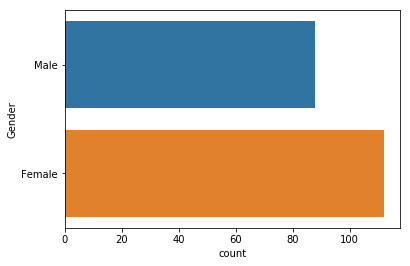

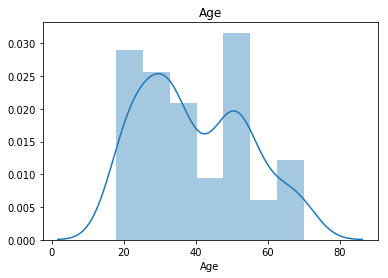

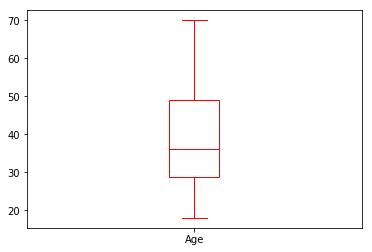

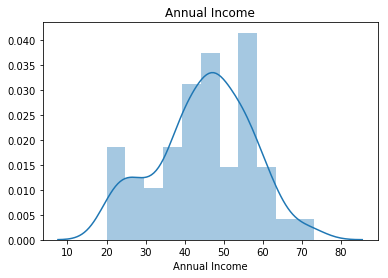

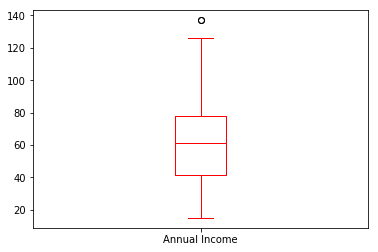

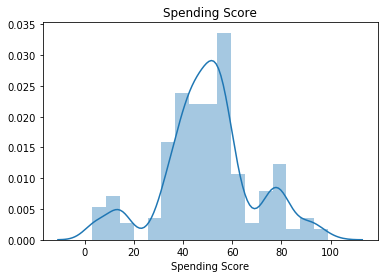

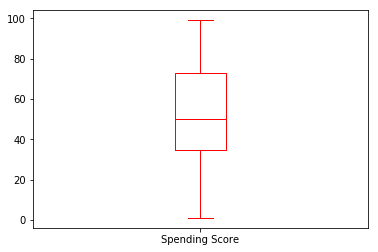

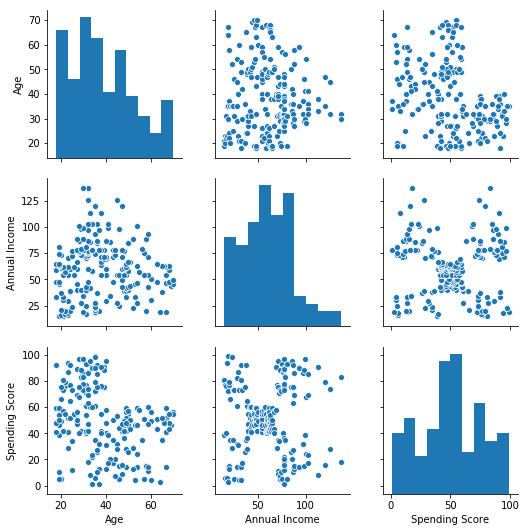

In [134]:
# 카테고리 데이터 확인
sns.countplot(y='Gender', data = df)
plt.show()
# 성별에서 적절히 퍼져있음을 확인

# 수 데이터 확인
numerical_feature = [col for col in df.columns if df[col].dtypes == 'int64']

# numerical data distribution, outlier 확인 
for col in numerical_feature:
    sns.distplot(df.loc[df[col], col])
    plt.title(col)
    plt.show()
    
    df[col].plot(kind = 'box', color = 'red')
    plt.show()
# outlier도 거의 없고, 분포도 어느정도 퍼져있음을 확인    

# 데이터간 분포 관계 확인
sns.pairplot(df[numerical_feature], x_vars = numerical_feature, y_vars=numerical_feature)
plt.show()
# Anuual income과 Spending score 관계에 있어서 어느정도 clustering이 존재함을 확인

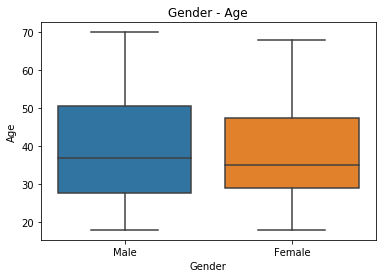

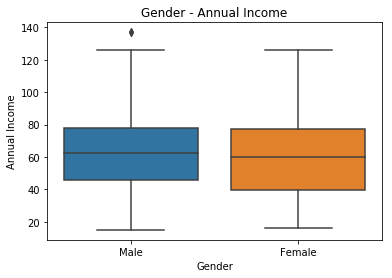

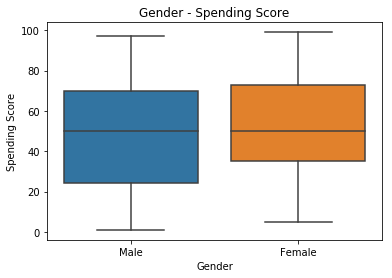

In [135]:
# 성별에 따른 numerical data 확인
for col in numerical_feature:
    sns.boxplot(x='Gender', y = col, data = df)
    plt.title('Gender - {}' .format(col))
    plt.show()
# 성별간 차이가 크지 않고, 잘 퍼져있음을 확인

In [136]:
# 카테고리 데이터 처리

le = LabelEncoder()

df['Gender'] = le.fit_transform(df['Gender'])

# 1 = male, 0 = female

df.head()

,Gender,Age,Annual Income,Spending Score
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


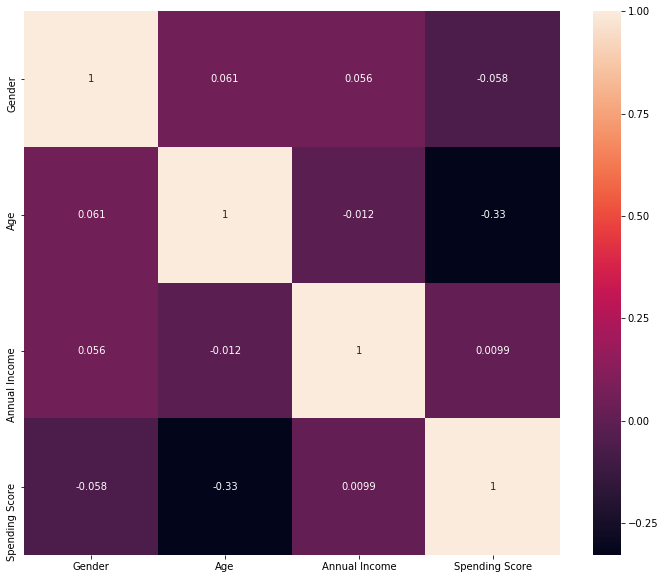

In [137]:

# correlation
# calculate the correlation matrix
corr = df.corr()
# adjust matrix size to (12, 10)
plt.subplots( figsize =( 12 , 10 ) )

# plot the correlation heatmap
sns.heatmap(corr,
        annot=True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# Age와 Spending score의 약간의 반비례적인 관계 확인

In [138]:

#scaler = RobustScaler()
#scaler = MinMaxScaler()
scaler = MaxAbsScaler()
#scaler = StandardScaler()
df[numerical_feature] = scaler.fit_transform(df[numerical_feature])

# from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# principalComponents = pca.fit_transform(df)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['Component1','Component2','Component3'])


In [139]:
# 후 k-means 사용 시, 군집의 개수를 inertia를 활용해서 정해보자.
def inertia_plot(inertia, gender):
    plt.figure(1, figsize = (12,6))
    plt.plot(np.arange(1, 11), inertia, 'o')
    plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    if gender == 0:
        title = "Female"
    else:
        title = "Male"
        
    plt.title(title)
    plt.show()

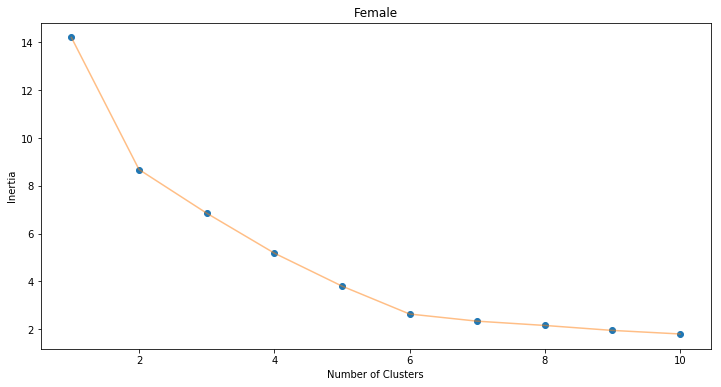

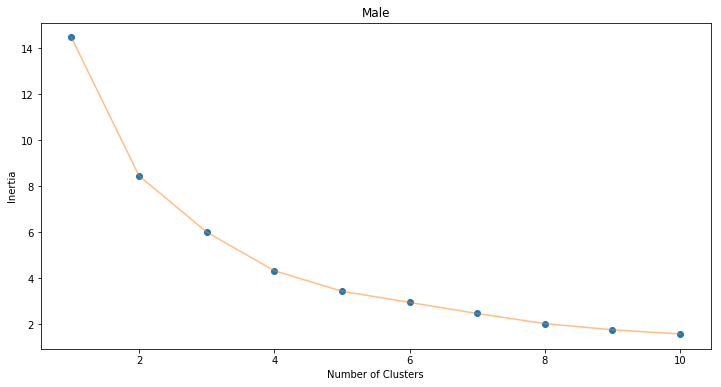

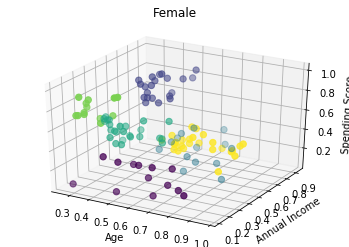

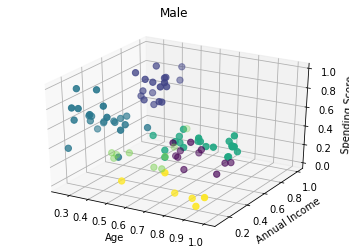

In [140]:
# 이전 결과에서 성별이 클러스터를 완전히 반으로 나눠버렸다.
# 하지만 고객의 소비성향을 보고 마케팅 전략을 구상하는 것이 목표므로 성별로만 나뉘어져서는 안된다.
# 성별을 먼저 나누고 학습해보자.

# 성별에 따른 결과 리스트
df_gender = []

# 0: Female, 1: Male
for gender in range(2):
    # 해당하는 성별 데이터 추출
    dfg = df[df.Gender == gender] 
    dfg = dfg.reset_index(drop=True)
    
    inertia = []
    for n in range(1, 11):
        # K-means algorithm
        kmeans = KMeans(n_clusters = n, init = 'k-means++', n_init = 10, random_state = 0).fit(dfg)
        inertia.append(kmeans.inertia_)
    
    inertia_plot(inertia, gender)
# 둘 다 클러스터의 개수로는 4~6로 적정할 것이라 판단.
# ==> 둘 다 클러스터의 개수로 6를 잡아보자.
    
    clusters = 6
    # K-means algorithm
    kmeans = KMeans(n_clusters = clusters,init = 'k-means++', n_init = 10, random_state = 0).fit_predict(dfg)
    cluster = pd.DataFrame(kmeans, columns=['cluster'])

    result = pd.concat([dfg, cluster], axis = 1)
    df_gender.append(result) # list append

    
# Clustering 시각화
for gender in range(len(df_gender)):
    result = df_gender[gender]
    
    # 3D 시각화
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(result['Age'], result['Annual Income'],result['Spending Score'], c = result['cluster'], s = 40)
    if gender == 0:
        title = "Female"
    else:
        title = "Male"
        
    ax.title.set_text(title)
    ax.set_xlabel('Age')
    ax.set_ylabel('Annual Income')
    ax.set_zlabel('Spending Score')
    plt.show()
    
# 어느정도 효과적인 결론이 도출되긴 어려운 것 같다.
# Annual income과 Spending score // Age와 Spending score
# 이렇게 2차원씩 시각화 해보자.


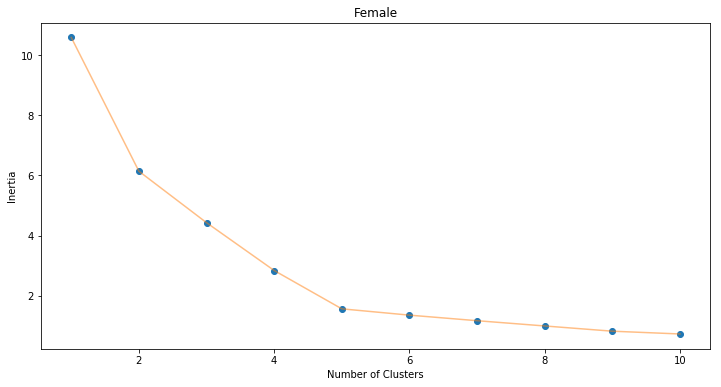

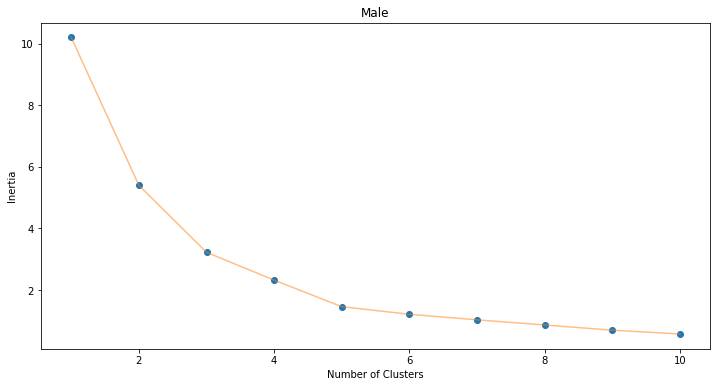

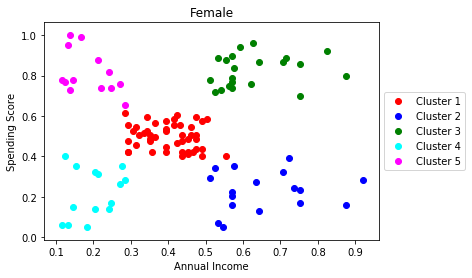

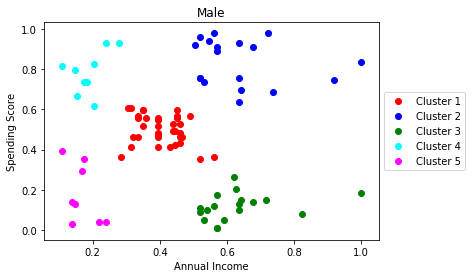

In [141]:
# Annual income - Spending score

# Age 삭제
df2 = df.drop(['Age'], axis = 1)

# 성별에 따른 결과 리스트
df_gender = []

# 0: Female, 1: Male
for gender in range(2):
    # 해당하는 성별 데이터 추출
    dfg = df2[df2.Gender == gender] 
    dfg = dfg.reset_index(drop=True)
    
    inertia = []
    for n in range(1, 11):
        # K-means algorithm
        kmeans = KMeans(n_clusters = n, init = 'k-means++', n_init = 10, random_state = 0).fit(dfg)
        inertia.append(kmeans.inertia_)
    
    inertia_plot(inertia, gender)
# 둘 다 클러스터의 개수로는 5개가 적당한 것 같다. 5개로 정하고 시각화해보자.
    
    clusters = 5
    # K-means algorithm
    kmeans = KMeans(n_clusters = clusters,init = 'k-means++', n_init = 10, random_state = 0).fit_predict(dfg)
    cluster = pd.DataFrame(kmeans, columns=['cluster'])

    result = pd.concat([dfg, cluster], axis = 1)
    df_gender.append(result) # list append

# Clustering 시각화
for gender in range(len(df_gender)):
    result = df_gender[gender]
   
    # 2D 시각화
    color_list = ['red', 'blue', 'green', 'cyan', 'magenta']
    labels = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5']
    
    # 클러스터에 따른 시각화
    for cluster_number in range(clusters):
        temp = result[result['cluster'] == cluster_number]
        plt.scatter(temp['Annual Income'], temp['Spending Score'], c = color_list[cluster_number], label = labels[cluster_number])
    if gender == 0:
        title = "Female"
    else:
        title = "Male"    
    plt.title(title)
    plt.xlabel('Annual Income')
    plt.ylabel('Spending Score')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


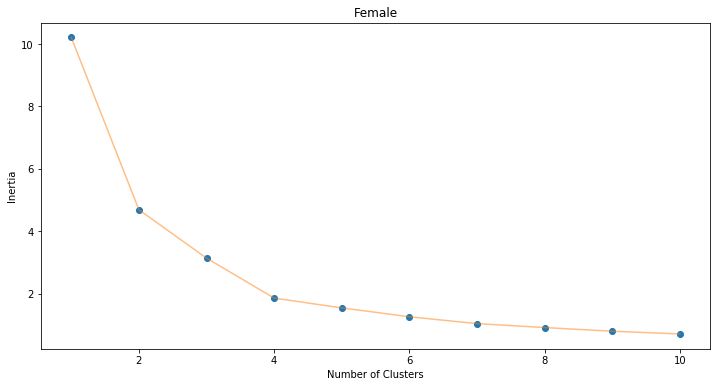

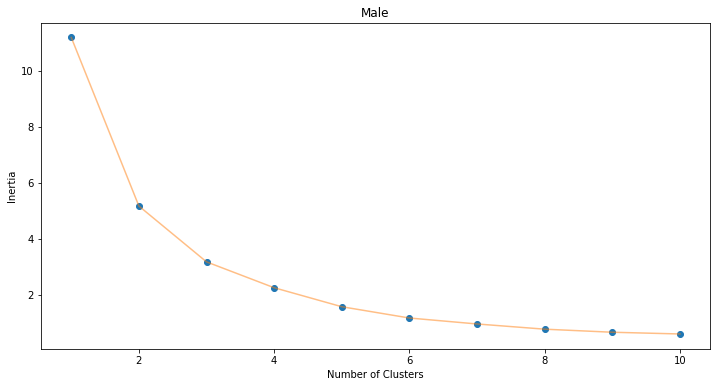

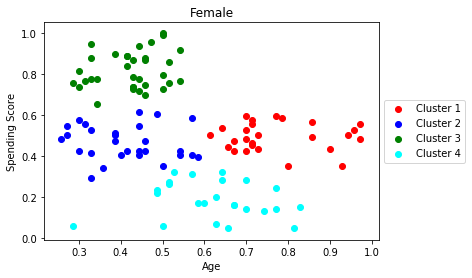

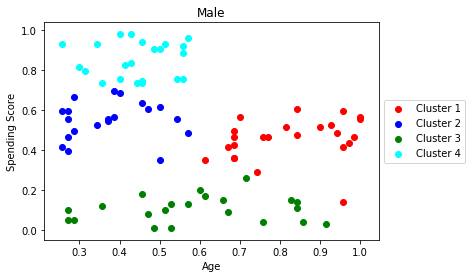

In [142]:
# Age - Spending score

# Annual Income 삭제
df2 = df.drop(['Annual Income'], axis = 1)

# 성별에 따른 결과 리스트
df_gender = []

# 0: Female, 1: Male
for gender in range(2):
    # 해당하는 성별 데이터 추출
    dfg = df2[df2.Gender == gender] 
    dfg = dfg.reset_index(drop=True)
    
    inertia = []
    for n in range(1, 11):
        # K-means algorithm
        kmeans = KMeans(n_clusters = n, init = 'k-means++', n_init = 10, random_state = 0).fit(dfg)
        inertia.append(kmeans.inertia_)
    
    inertia_plot(inertia, gender)
# 둘 다 클러스터의 개수로는 4개가 적당한 것 같다. 4개로 정하고 시각화해보자.
    
    clusters = 4
    # K-means algorithm
    kmeans = KMeans(n_clusters = clusters,init = 'k-means++', n_init = 10, random_state = 0).fit_predict(dfg)
    cluster = pd.DataFrame(kmeans, columns=['cluster'])

    result = pd.concat([dfg, cluster], axis = 1)
    df_gender.append(result) # list append

# Clustering 시각화
for gender in range(len(df_gender)):
    result = df_gender[gender]
   
    # 2D 시각화
    color_list = ['red', 'blue', 'green', 'cyan']
    labels = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4']
    
    # 클러스터에 따른 시각화
    for cluster_number in range(clusters):
        temp = result[result['cluster'] == cluster_number]
        plt.scatter(temp['Age'], temp['Spending Score'], c = color_list[cluster_number], label = labels[cluster_number])
    
    if gender == 0:
        title = "Female"
    else:
        title = "Male"    
    plt.title(title)
    plt.xlabel('Age')
    plt.ylabel('Spending Score')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
